# Dealing with Partial Observability In Reinforcement Learning
> "Using RLlib, frame stacking, and self-attention to master environments with partial observations."

- hide: true
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, gym, ray, rllib, tensorflow, machine learning, reinforcement learning, sequence, attention]
- image: images/cartpole.jpg

> Important: This blog post is still work in progress.

In reinforcement learning (RL), the RL agent typically selects a suitable action based on the last observation.
In many practical environments, the full state can only be observed partially,
such that important information may be missing when just considering the last observation.
This blog post covers options for dealing with missing and only partially observed state,
e.g., considering a *sequence* of last observations and applying *self-attention* to this sequence.

> Note: This blog post is based on and very related to [Anyscale's blog post on attention nets with RLlib](https://www.anyscale.com/blog/attention-nets-and-more-with-rllibs-trajectory-view-api). In comparison, I focus less on RLlib's trajectory API and more on providing a practical, end-to-end tutorial.


## Example: The CartPole Gym Environment

As an example, consider the popular [OpenAI Gym CartPole environment](https://gym.openai.com/envs/CartPole-v1/).
Here, the task is to move a cart left or right in order to balance a pole on the cart as long as possible.

![OpenAI Gym CartPole-v1 Environment](attention/cartpole.gif "OpenAI Gym CartPole-v1 Environment")

In the normal [`CartPole-v1` environment](https://gym.openai.com/envs/CartPole-v1/), the RL agent observes four scalar values ([defined here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L26:L32)):
* The cart position, i.e., where the cart currently is.
* The cart velocity, i.e., how fast the cart is currently moving and in which direction (can be positive or negative).
* The pole angle, i.e., how tilted the pole currently is and in which direction.
* The pole angular velocity, i.e., how fast the pole is currently moving and in which direction.

All four observations are important to decide whether the cart should move left or right.

Now, assume the RL agent only has access to an instant snapshot of the cart and the pole (e.g., through a photo/raw pixels)
and can neither observe cart velocity nor pole angular velocity.
In this case, the RL agent only has partial observations and does not know whether and how fast the pole is currently swinging.
As a result, standard RL agents cannot solve the problem and do not learn to balance the pole.
How to deal with this problem of partial observations, i.e., missing state (here, cart and pole velocity)?


## Options for Dealing With Partial Observations

There are different options for dealing with partial observations/missing state, e.g., missing velocity in the CartPole example:

1. Add the missing state explicitly, e.g., measure and observe velocity. Note that this may require installing extra sensors or may even be infeasible in some scenarios.
2. Ignore the missing state, i.e., just rely on the available, partial observations. Depending on the missing state, this may be problematic and keep the agent from learning.
3. Keep track of a sequence of the last observations. By observing the cart position and pole angle over time, the agent can implicitly derive their velocity. There are different ways to deal with this sequence:
   1. Just use the sequence as is for a standard multi-layer perceptron (MLP)/dense feedforward neural network.
   2. Feed the sequence into a recurrent neural network (RNN), e.g., with long short-term memory (LSTM).
   3. Feed the sequence into a neural network with *self-attention*.

In the following, I go through each option in more detail and illustrate them using simple example code.


### Setup

For the examples, I use a PPO RL agent from Ray RLlib with the CartPole environment, described above.

To install these dependencies, run the following code (tested with Python 3.8 on Windows):

In [ ]:
#collapse-output
!pip install ray[rllib]==1.8.0
!pip install tensorflow==2.7.0
!pip install seaborn==0.11.2
!pip install gym==0.21.0
!pip install pyglet==1.5.21

Start up ray, load the default PPO config, and determine the number of training iterations,
which is the same for all options (for comparability).

In [ ]:
import ray
from ray.rllib.agents import ppo

# adjust num_cpus and num_gpus to your system
# for some reason, num_cpus=2 gets stuck on my system (when trying to train)
ray.init(num_cpus=3, ignore_reinit_error=True)

# stop conditions based on training iterations (each with 4000 train steps)
stop = {"training_iteration": 10}

### Option 1: Explicitly Add Missing State

Sometimes, it is possible to extend the observations and explicitly add important state that was previously unobserved.
In the CartPole example, the cart and pole velocity can simply be "added" by using the default `CartPole-v1` environment.
Here, the cart velocity and pole velocity are already included in the observations.

Note that in many practical scenarios such "missing" state cannot be added and observed simply.
Instead, it may require installing additional sensors or may even be completely infeasible.

Let's start with the best case, i.e., explicitly including the missing state.

In [ ]:
import gym

# the default CartPole env has all 4 observations: position and velocity of both cart and pole
env = gym.make("CartPole-v1")
env.observation_space.shape

In [ ]:
#collapse-output

# run PPO on the default CartPole-v1 env
config1 = ppo.DEFAULT_CONFIG.copy()
config1["env"] = "CartPole-v1"

# training takes a while
results1 = ray.tune.run("PPO", config=config1, stop=stop)
print("Option 1: Training finished successfully")

(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 20:06:53 (running for 00:00:05.17)
Memory usage on this node: 10.0/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------+----------+-------+
| Trial name                  | status   | loc   |
|-----------------------------+----------+-------|
| PPO_CartPole-v1_805a6_00000 | PENDING  |       |
+-----------------------------+----------+-------+




(pid=12392) 2021-11-29 20:07:09,418	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=12392) 2021-11-29 20:07:09,418	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=12392) 2021-11-29 20:07:09,418	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=18060) 2021-11-29 20:07:26,440	WARNING deprecation.py:38 -- Deprec

== Status ==
Current time: 2021-11-29 20:07:30 (running for 00:00:42.38)
Memory usage on this node: 10.5/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------+----------+-----------------+
| Trial name                  | status   | loc             |
|-----------------------------+----------+-----------------|
| PPO_CartPole-v1_805a6_00000 | RUNNING  | 127.0.0.1:12392 |
+-----------------------------+----------+-----------------+




(pid=12392) 2021-11-29 20:07:30,315	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=12392) 2021-11-29 20:07:30,315	INFO trainable.py:110 -- Trainable.setup took 20.899 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=12392) 2021-11-29 20:07:30,317	WARNING util.py:57 -- Install gputil for GPU system monitoring.


== Status ==
Current time: 2021-11-29 20:07:31 (running for 00:00:43.42)
Memory usage on this node: 10.6/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------+----------+-----------------+
| Trial name                  | status   | loc             |
|-----------------------------+----------+-----------------|
| PPO_CartPole-v1_805a6_00000 | RUNNING  | 127.0.0.1:12392 |
+-----------------------------+----------+-----------------+




(pid=12392) 2021-11-29 20:07:36,059	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


== Status ==
Current time: 2021-11-29 20:07:36 (running for 00:00:48.48)
Memory usage on this node: 10.6/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------+----------+-----------------+
| Trial name                  | status   | loc             |
|-----------------------------+----------+-----------------|
| PPO_CartPole-v1_805a6_00000 | RUNNING  | 127.0.0.1:12392 |
+-----------------------------+----------+-----------------+


== Status ==
Current time: 2021-11-29 20:07:41 (running for 00:00:53.55)
Memory usage on this node: 10.6/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------+----------+-----------------+
| Trial name

(pid=12392) [2021-11-29 20:09:38,028 E 12392 25260] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=12392) Windows fatal exception: access violation
(pid=12392) 
(pid=18060) [2021-11-29 20:09:38,032 E 18060 18660] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=18060) Windows fatal exception: access violation
(pid=18060) 
(pid=24624) [2021-11-29 20:09:38,055 C 24624 21852] core_worker.cc:2234:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=24624) *** StackTrace Information ***
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__raylet
(pid=24624)     PyInit__rayl

Option 1: Training finished successfully


In [ ]:
# check results
results1.default_metric = "episode_reward_mean"
results1.default_mode = "max"
# print mean number of time steps the pole was balanced (higher = better)
results1.best_result["episode_reward_mean"]

302.23

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


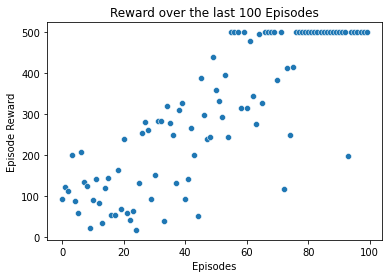

In [ ]:
# plot the last 100 episode rewards
import seaborn as sns

def plot_rewards(results):
    """Plot scatter plot of the last 100 training episodes"""
    eps_rewards = results.best_result["hist_stats"]["episode_reward"]
    eps = [i for i in range(len(eps_rewards))]
    ax = sns.scatterplot(eps, eps_rewards)
    ax.set_title("Reward over the last 100 Episodes")
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Episode Reward")


plot_rewards(results1)


Including the missing state helps the agent learn a good policy quickly, leading to high reward.


## Option 2: Ignore Missing State

In many practical scenarios, missing state cannot be simply added to complete the partial observations,
e.g., because measuring/capturing the missing observations incurs prohibitive costs or is physically not feasible.

In this case, the simplest alternative is using the partial observations as they are available.
This works if the observations still include enough information to learn a useful policy.

However, if too much important information is missing, learning a useful policy becomes slow or even impossible.
In the CartPole example, partial observations that do not include the velocity of the cart and the pole keep the agent from learning a useful policy.


In [ ]:
#collapse-output

from ray.rllib.examples.env.stateless_cartpole import StatelessCartPole
from ray.tune import registry

registry.register_env("StatelessCartPole", lambda _: StatelessCartPole())
config2 = ppo.DEFAULT_CONFIG.copy()
config2["env"] = "StatelessCartPole"
# train; this takes a while
results2 = ray.tune.run("PPO", config=config2, stop=stop)
print("Option 2: Training finished successfully")

== Status ==
Current time: 2021-11-29 20:09:38 (running for 00:00:00.15)
Memory usage on this node: 9.5/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_e604a_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 20:09:43 (running for 00:00:05.16)
Memory usage on this node: 9.5/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_e604a_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=17364) 2021-11-29 20:09:56,619	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=17364) 2021-11-29 20:09:56,619	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=17364) 2021-11-29 20:09:56,620	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=4720) 2021-11-29 20:10:23,191	WARNING deprecation.py:38 -- Depreca

== Status ==
Current time: 2021-11-29 20:10:30 (running for 00:00:51.61)
Memory usage on this node: 10.3/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+-----------------+
| Trial name                        | status   | loc             |
|-----------------------------------+----------+-----------------|
| PPO_StatelessCartPole_e604a_00000 | RUNNING  | 127.0.0.1:17364 |
+-----------------------------------+----------+-----------------+




(pid=17364) 2021-11-29 20:10:30,083	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=17364) 2021-11-29 20:10:30,083	INFO trainable.py:110 -- Trainable.setup took 33.481 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=17364) 2021-11-29 20:10:30,085	WARNING util.py:57 -- Install gputil for GPU system monitoring.


== Status ==
Current time: 2021-11-29 20:10:31 (running for 00:00:52.68)
Memory usage on this node: 10.3/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+-----------------+
| Trial name                        | status   | loc             |
|-----------------------------------+----------+-----------------|
| PPO_StatelessCartPole_e604a_00000 | RUNNING  | 127.0.0.1:17364 |
+-----------------------------------+----------+-----------------+


== Status ==
Current time: 2021-11-29 20:10:36 (running for 00:00:57.72)
Memory usage on this node: 10.3/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+------

(pid=17364) 2021-11-29 20:10:36,948	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


== Status ==
Current time: 2021-11-29 20:10:41 (running for 00:01:02.96)
Memory usage on this node: 10.3/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+-----------------+
| Trial name                        | status   | loc             |
|-----------------------------------+----------+-----------------|
| PPO_StatelessCartPole_e604a_00000 | RUNNING  | 127.0.0.1:17364 |
+-----------------------------------+----------+-----------------+


Result for PPO_StatelessCartPole_e604a_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-29_20-10-43
  done: false
  episode_len_mean: 21.917582417582416
  episode_media: {}
  episode_reward_max: 63.0
  episode_reward_mean: 21.917582417582416
  episode_reward_min: 8.0
  episodes_this_iter: 182
  episodes_total: 182
  experiment

(pid=17364) [2021-11-29 20:12:51,789 E 17364 20352] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=17364) Windows fatal exception: access violation
(pid=17364) 
(pid=4720) [2021-11-29 20:12:51,806 E 4720 24304] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=2284) [2021-11-29 20:12:51,807 E 2284 21460] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
2021-11-29 20:12:51,930	INFO tune.py:630 -- Total run time: 193.41 seconds (192.98 seconds for the tuning loop).
(pid=4720) Windows fatal exception: access violation


Option 2: Training finished successfully


(pid=4720) 
(pid=2284) Windows fatal exception: access violation
(pid=2284) 


In [ ]:
# check results
results2.default_metric = "episode_reward_mean"
results2.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results2.best_result["episode_reward_mean"]

48.46

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


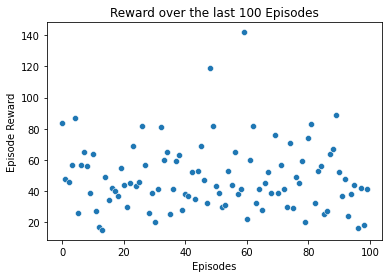

In [ ]:
plot_rewards(results2)

With only the partial observations, i.e., without observing velocity, the RL agent does not learn a useful policy.
The reward does not increase notably over time and the resulting episode reward is rather small.


## Option 3: Use Sequence of Last Observations

Even if the velocity of cart and pole are not explicitly available in this example,
it can be derived by the RL agent by looking at a *sequence* of previous observations.
If the cart is always at the same position, its velocity is likely close to zero.
If its position varies greatly, it likely has high velocity.

Hence, one useful approach is to simply stack the last $n$ observations and providing this sequence as input to the RL agent.


### Option 3a: Use Raw Sequence as Input

Here, I consider the same default feed-forward neural network with PPO, just providing the stacked, partial observations as input.

#### Stacking Observations Using Gym's `FrameStack` Wrapper

To stack the last $n$ observations, I use Gym's `FrameStack` wrapper. As an example, I choose $n=4$.

In [ ]:
from gym.wrappers import FrameStack

NUM_FRAMES = 4

# stateless CartPole --> only 2 observations: position of cart & angle of pole (not: velocity of cart or pole)
env = StatelessCartPole()
print(f"Shape of observation space (stateless CartPole): {env.observation_space.shape}")

# stack last n observations into sequence --> n x 2
env_stacked = FrameStack(env, NUM_FRAMES)
print(f"Shape of observation space (stacked stateless CartPole): {env_stacked.observation_space.shape}")

# register env for RLlib
registry.register_env("StackedStatelessCartPole", lambda _: FrameStack(StatelessCartPole(), NUM_FRAMES))

Shape of observation space (stateless CartPole): (2,)
Shape of observation space (stacked stateless CartPole): (4, 2)


In [ ]:
#collapse-output

# use PPO with vanilla MLP
config3a = ppo.DEFAULT_CONFIG.copy()
config3a["env"] = "StackedStatelessCartPole"
# train; this takes a while
results3a = ray.tune.run("PPO", config=config3a, stop=stop)
print("Option 3a with FrameStack: Training finished successfully")

== Status ==
Current time: 2021-11-29 20:12:52 (running for 00:00:00.17)
Memory usage on this node: 9.4/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+------------------------------------------+----------+-------+
| Trial name                               | status   | loc   |
|------------------------------------------+----------+-------|
| PPO_StackedStatelessCartPole_59a83_00000 | PENDING  |       |
+------------------------------------------+----------+-------+




(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 20:12:57 (running for 00:00:05.17)
Memory usage on this node: 9.5/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+------------------------------------------+----------+-------+
| Trial name                               | status   | loc   |
|------------------------------------------+----------+-------|
| PPO_StackedStatelessCartPole_59a83_00000 | PENDING  |       |
+------------------------------------------+----------+-------+




(pid=12804) 2021-11-29 20:13:10,186	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=12804) 2021-11-29 20:13:10,187	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=12804) 2021-11-29 20:13:10,187	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=6688) c:\users\stefan\git-repos\private\blog\venv\lib\site-package

== Status ==
Current time: 2021-11-29 20:13:36 (running for 00:00:44.29)
Memory usage on this node: 10.2/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+------------------------------------------+----------+-----------------+
| Trial name                               | status   | loc             |
|------------------------------------------+----------+-----------------|
| PPO_StackedStatelessCartPole_59a83_00000 | RUNNING  | 127.0.0.1:12804 |
+------------------------------------------+----------+-----------------+




(pid=12804) 2021-11-29 20:13:36,800	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=12804) 2021-11-29 20:13:36,800	INFO trainable.py:110 -- Trainable.setup took 26.626 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=12804) 2021-11-29 20:13:36,802	WARNING util.py:57 -- Install gputil for GPU system monitoring.


== Status ==
Current time: 2021-11-29 20:13:37 (running for 00:00:45.36)
Memory usage on this node: 10.2/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+------------------------------------------+----------+-----------------+
| Trial name                               | status   | loc             |
|------------------------------------------+----------+-----------------|
| PPO_StackedStatelessCartPole_59a83_00000 | RUNNING  | 127.0.0.1:12804 |
+------------------------------------------+----------+-----------------+


== Status ==
Current time: 2021-11-29 20:13:42 (running for 00:00:50.45)
Memory usage on this node: 10.3/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-------

(pid=12804) 2021-11-29 20:13:45,344	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


== Status ==
Current time: 2021-11-29 20:13:48 (running for 00:00:55.57)
Memory usage on this node: 10.2/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+------------------------------------------+----------+-----------------+
| Trial name                               | status   | loc             |
|------------------------------------------+----------+-----------------|
| PPO_StackedStatelessCartPole_59a83_00000 | RUNNING  | 127.0.0.1:12804 |
+------------------------------------------+----------+-----------------+


== Status ==
Current time: 2021-11-29 20:13:53 (running for 00:01:00.67)
Memory usage on this node: 10.2/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-------

(pid=6688) [2021-11-29 20:16:03,434 C 6688 4772] core_worker.cc:796:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=6688) *** StackTrace Information ***
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyInit__raylet
(pid=6688)     PyNumber_InPlaceLshift
(pid=6688)     Py_CheckFunctionResult
(pid=6688)     PyEval_EvalFrameDefault
(pid=6688)     Py_CheckFunctionResult
(pid=6688)     PyEval_EvalFrameDefault
(pid=6688)     PyEval_EvalCodeWithName
(pid=6688)     PyEval_EvalCodeEx
(pid=6688)     PyEval_EvalCode
(pid=6688)     PyArena_New
(pid=6688)     PyArena_New
(p

Option 3a with FrameStack: Training finished successfully


In [ ]:
# check results
results3a.default_metric = "episode_reward_mean"
results3a.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3a.best_result["episode_reward_mean"]

199.58

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


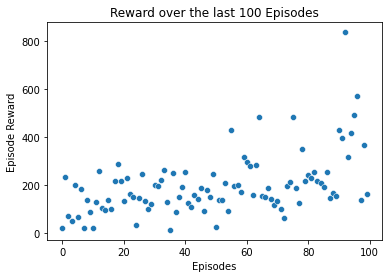

In [ ]:
plot_rewards(results3a)

Simply by stacking the last $n$ observations, the RL agent learns a useful policy again -
even though each observation is still partial, i.e., missing the cart and pole velocity.


#### Stacking Observations Using RLlib's Trajectory API

Above, I used Gym's `FrameStack` wrapper to stack the last $n$ observations inside the environment.
Alternatively, the stacking can be implemented on the model side, e.g., using RLlib's trajectory API,
which reduces space complexity for storing the stacked observations but should lead to similar results.

In [ ]:
#collapse-output

from ray.rllib.examples.models.trajectory_view_utilizing_models import FrameStackingCartPoleModel
from ray.rllib.models.catalog import ModelCatalog

ModelCatalog.register_custom_model("stacking_model", FrameStackingCartPoleModel)

config3a2 = ppo.DEFAULT_CONFIG.copy()
config3a2["env"] = "StatelessCartPole"
config3a2["model"] = {
    "custom_model": "stacking_model",
    "custom_model_config": {
        "num_frames": NUM_FRAMES,
    }
}

results3a2 = ray.tune.run("PPO", config=config3a2, stop=stop)
print("Option 3a2 with Trajectory API: Training finished successfully")

== Status ==
Current time: 2021-11-29 20:16:04 (running for 00:00:00.15)
Memory usage on this node: 8.9/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_cbc6d_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 20:16:09 (running for 00:00:05.15)
Memory usage on this node: 8.9/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_cbc6d_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=16612) 2021-11-29 20:16:24,131	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=16612) 2021-11-29 20:16:24,132	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=16612) 2021-11-29 20:16:24,132	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=23744) 2021-11-29 20:16:43,019	WARNING deprecation.py:38 -- Deprec

== Status ==
Current time: 2021-11-29 20:16:47 (running for 00:00:43.55)
Memory usage on this node: 9.7/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+-----------------+
| Trial name                        | status   | loc             |
|-----------------------------------+----------+-----------------|
| PPO_StatelessCartPole_cbc6d_00000 | RUNNING  | 127.0.0.1:16612 |
+-----------------------------------+----------+-----------------+


== Status ==
Current time: 2021-11-29 20:16:48 (running for 00:00:44.59)
Memory usage on this node: 9.7/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+--------

(pid=16612) 2021-11-29 20:16:53,842	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


== Status ==
Current time: 2021-11-29 20:16:58 (running for 00:00:54.77)
Memory usage on this node: 9.7/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+-----------------+
| Trial name                        | status   | loc             |
|-----------------------------------+----------+-----------------|
| PPO_StatelessCartPole_cbc6d_00000 | RUNNING  | 127.0.0.1:16612 |
+-----------------------------------+----------+-----------------+


Result for PPO_StatelessCartPole_cbc6d_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-29_20-16-59
  done: false
  episode_len_mean: 21.76502732240437
  episode_media: {}
  episode_reward_max: 92.0
  episode_reward_mean: 21.76502732240437
  episode_reward_min: 8.0
  episodes_this_iter: 183
  episodes_total: 183
  experiment_id

(pid=16612) [2021-11-29 20:18:55,642 E 16612 15072] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=16612) Windows fatal exception: access violation
(pid=16612) 
(pid=23744) [2021-11-29 20:18:55,655 C 23744 10616] core_worker.cc:796:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=23744) *** StackTrace Information ***
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyInit__raylet
(pid=23744)     PyNumber_InPlaceLshift
(pid=23744)     Py_CheckFunctionResult
(pid=23744)     PyEval_EvalFrameDefault


Option 3a2 with Trajectory API: Training finished successfully


In [ ]:
# check results
results3a2.default_metric = "episode_reward_mean"
results3a2.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3a2.best_result["episode_reward_mean"]

85.58

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


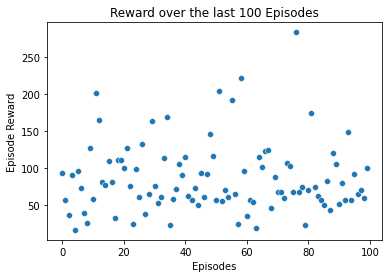

In [ ]:
plot_rewards(results3a2)

### Option 3b: Use an LSTM for Processing the Sequence

Instead of stacking the last $n$ observations and providing this sequence as input to a regular feed-forward neural network,
a recurrent neural network (RNN) can be used, keeping track of a learned *state* that is passed onwards from observation to observation.

Long short-term memory (LSTM) networks are a variant of RNNs that are good at keeping state for longer durations.
To use an LSTM with RLlib, simply set the corresponding flag in the model config:

In [ ]:
#collapse-output

config3b = ppo.DEFAULT_CONFIG.copy()
config3b["env"] = "StatelessCartPole"
config3b["model"] = {
    "use_lstm": True,
    # "max_seq_len": 10,
}

results3b = ray.tune.run("PPO", config=config3b, stop=stop)
print("Option 3b: Training finished successfully")

== Status ==
Current time: 2021-11-29 20:18:56 (running for 00:00:00.15)
Memory usage on this node: 9.0/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_327c4_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 20:19:01 (running for 00:00:05.16)
Memory usage on this node: 9.0/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_327c4_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=2516) 2021-11-29 20:19:14,439	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=2516) 2021-11-29 20:19:14,439	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=2516) 2021-11-29 20:19:14,439	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=18292) 2021-11-29 20:19:36,695	WARNING deprecation.py:38 -- Deprecati

== Status ==
Current time: 2021-11-29 20:19:47 (running for 00:00:50.74)
Memory usage on this node: 9.8/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_327c4_00000 | RUNNING  | 127.0.0.1:2516 |
+-----------------------------------+----------+----------------+




(pid=2516) 2021-11-29 20:19:47,028	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=2516) 2021-11-29 20:19:47,028	INFO trainable.py:110 -- Trainable.setup took 32.601 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=2516) 2021-11-29 20:19:47,031	WARNING util.py:57 -- Install gputil for GPU system monitoring.


== Status ==
Current time: 2021-11-29 20:19:48 (running for 00:00:51.84)
Memory usage on this node: 9.8/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_327c4_00000 | RUNNING  | 127.0.0.1:2516 |
+-----------------------------------+----------+----------------+


== Status ==
Current time: 2021-11-29 20:19:53 (running for 00:00:56.92)
Memory usage on this node: 9.8/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+--

(pid=2516) 2021-11-29 20:19:58,448	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


== Status ==
Current time: 2021-11-29 20:20:03 (running for 00:01:07.20)
Memory usage on this node: 9.9/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_327c4_00000 | RUNNING  | 127.0.0.1:2516 |
+-----------------------------------+----------+----------------+


== Status ==
Current time: 2021-11-29 20:20:09 (running for 00:01:12.73)
Memory usage on this node: 9.9/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+--

2021-11-29 20:34:13,168	WARNING ray_trial_executor.py:768 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for PPO_StatelessCartPole_327c4_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-11-29_20-34-13
  done: false
  episode_len_mean: 36.22727272727273
  episode_media: {}
  episode_reward_max: 111.0
  episode_reward_mean: 36.22727272727273
  episode_reward_min: 9.0
  episodes_this_iter: 110
  episodes_total: 1169
  experiment_id: 3e8fca67a3c24c2f8f19711229666be8
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.15000000596046448
          cur_lr: 4.999999873689376e-05
          entropy: 0.5780143737792969
          entropy_coeff: 0.0
          kl: 0.019415993243455887
          model: {}
          policy_loss: -0.012010929174721241
          total_loss: 131.65951538085938
          vf_explained_var: 0.2506897449493408
          vf_loss: 131.66860961914062
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_steps_tra

(pid=2516) [2021-11-29 20:36:04,454 E 2516 20700] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=2516) Windows fatal exception: access violation
(pid=2516) 
(pid=18292) [2021-11-29 20:36:04,458 E 18292 11584] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=18292) Windows fatal exception: access violation
(pid=18292) 
(pid=24860) [2021-11-29 20:36:04,444 E 24860 3248] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=24860) Windows fatal exception: access violation
(pid=24860) 
2021-11-29 20:36:04,608	INFO tune.py:630 -- Total run time: 1028.31 seconds (1027.81 seconds for the tuning loop).


Option 3b: Training finished successfully


In [ ]:
# check results
results3b.default_metric = "episode_reward_mean"
results3b.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3b.best_result["episode_reward_mean"]

40.88

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


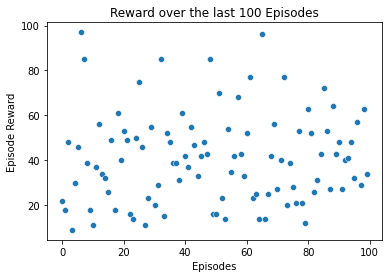

In [ ]:
plot_rewards(results3b)

#### LSTM with Stacked Observations

Using the `StackedStatelessCartPole` from above.

In [ ]:
#collapse-output

config3b2 = ppo.DEFAULT_CONFIG.copy()
config3b2["env"] = "StackedStatelessCartPole"
config3b2["model"] = {
    "use_lstm": True,
}

results3b2 = ray.tune.run("PPO", config=config3b2, stop=stop)
print("Option 3b2: Training finished successfully")

== Status ==
Current time: 2021-11-29 20:36:05 (running for 00:00:00.16)
Memory usage on this node: 9.4/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+------------------------------------------+----------+-------+
| Trial name                               | status   | loc   |
|------------------------------------------+----------+-------|
| PPO_StackedStatelessCartPole_97cd0_00000 | PENDING  |       |
+------------------------------------------+----------+-------+


== Status ==
Current time: 2021-11-29 20:36:10 (running for 00:00:05.16)
Memory usage on this node: 9.4/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+------------------------------------------+----------+-------+


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=21312) 2021-11-29 20:36:30,075	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=21312) 2021-11-29 20:36:30,076	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=21312) 2021-11-29 20:36:30,076	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-package

== Status ==
Current time: 2021-11-29 20:37:02 (running for 00:00:57.48)
Memory usage on this node: 9.8/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+------------------------------------------+----------+-----------------+
| Trial name                               | status   | loc             |
|------------------------------------------+----------+-----------------|
| PPO_StackedStatelessCartPole_97cd0_00000 | RUNNING  | 127.0.0.1:21312 |
+------------------------------------------+----------+-----------------+


== Status ==
Current time: 2021-11-29 20:37:03 (running for 00:00:58.65)
Memory usage on this node: 9.8/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+---------

(pid=21312) 2021-11-29 20:37:13,599	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


== Status ==
Current time: 2021-11-29 20:37:15 (running for 00:01:10.06)
Memory usage on this node: 9.8/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+------------------------------------------+----------+-----------------+
| Trial name                               | status   | loc             |
|------------------------------------------+----------+-----------------|
| PPO_StackedStatelessCartPole_97cd0_00000 | RUNNING  | 127.0.0.1:21312 |
+------------------------------------------+----------+-----------------+


== Status ==
Current time: 2021-11-29 20:37:20 (running for 00:01:15.25)
Memory usage on this node: 9.9/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+---------

(pid=21312) [2021-11-29 20:53:11,042 E 21312 25312] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=21312) Windows fatal exception: access violation
(pid=21312) 
(pid=25036) [2021-11-29 20:53:11,060 C 25036 19756] core_worker.cc:796:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=25036) *** StackTrace Information ***
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyInit__raylet
(pid=25036)     PyNumber_InPlaceLshift
(pid=25036)     Py_CheckFunctionResult
(pid=25036)     PyEval_EvalFrameDefault


Option 3b2: Training finished successfully


In [ ]:
# check results
results3b2.default_metric = "episode_reward_mean"
results3b2.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3b2.best_result["episode_reward_mean"]

42.89

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


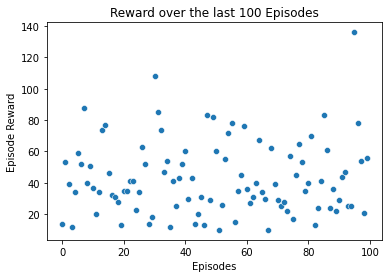

In [ ]:
plot_rewards(results3b2)

### Option 3c: Use Attention for Processing the Sequence

Self-attention is a recent and popular alternative to RNNs for processing sequence data.
Currently, the transformer architecture using self-attention is state of the art for natural language processing (NLP) tasks.

A similar, yet slightly modified architecture using attention is also useful for RL (see [related paper](https://arxiv.org/abs/1910.06764)).
Again, enabling attention in RLlib simply requires setting the corresponding flag in the model config:

In [ ]:
#collapse-output

config3c = ppo.DEFAULT_CONFIG.copy()
config3c["env"] = "StatelessCartPole"
config3c["model"] = {
    # Attention net wrapping (for tf) can already use the native keras
    # model versions. For torch, this will have no effect.
    "_use_default_native_models": True,
    "use_attention": True,
    # "max_seq_len": 10,
    # "attention_num_transformer_units": 1,
    # "attention_dim": 32,
    # "attention_memory_inference": 10,
    # "attention_memory_training": 10,
    # "attention_num_heads": 1,
    # "attention_head_dim": 32,
    # "attention_position_wise_mlp_dim": 32,
}

results3c = ray.tune.run("PPO", config=config3c, stop=stop)
print("Option 3c: Training finished successfully")

== Status ==
Current time: 2021-11-29 20:53:12 (running for 00:00:00.18)
Memory usage on this node: 9.6/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_fbbe6_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 20:53:17 (running for 00:00:05.19)
Memory usage on this node: 9.6/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_fbbe6_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=6604) 2021-11-29 20:53:34,878	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=6604) 2021-11-29 20:53:34,878	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=6604) 2021-11-29 20:53:34,878	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 20:54:21 (running for 00:01:09.37)
Memory usage on this node: 9.6/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_fbbe6_00000 | RUNNING  | 127.0.0.1:6604 |
+-----------------------------------+----------+----------------+




(pid=6604) 2021-11-29 20:54:21,273	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=6604) 2021-11-29 20:54:21,273	INFO trainable.py:110 -- Trainable.setup took 46.414 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=6604) 2021-11-29 20:54:21,276	WARNING util.py:57 -- Install gputil for GPU system monitoring.


== Status ==
Current time: 2021-11-29 20:54:22 (running for 00:01:10.42)
Memory usage on this node: 9.6/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_fbbe6_00000 | RUNNING  | 127.0.0.1:6604 |
+-----------------------------------+----------+----------------+


== Status ==
Current time: 2021-11-29 20:54:27 (running for 00:01:15.55)
Memory usage on this node: 9.7/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+--

2021-11-29 20:54:32,668	WARNING trial_runner.py:714 -- Trial Runner checkpointing failed: [WinError 5] Zugriff verweigert: 'C:\\Users\\Stefan\\ray_results\\PPO\\.tmp_checkpoint' -> 'C:\\Users\\Stefan\\ray_results\\PPO\\experiment_state-2021-11-29_20-53-11.json'


== Status ==
Current time: 2021-11-29 20:54:32 (running for 00:01:20.71)
Memory usage on this node: 9.7/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_fbbe6_00000 | RUNNING  | 127.0.0.1:6604 |
+-----------------------------------+----------+----------------+




2021-11-29 20:54:33,704	WARNING trial_runner.py:714 -- Trial Runner checkpointing failed: [WinError 5] Zugriff verweigert: 'C:\\Users\\Stefan\\ray_results\\PPO\\.tmp_checkpoint' -> 'C:\\Users\\Stefan\\ray_results\\PPO\\experiment_state-2021-11-29_20-53-11.json'
(pid=6604) 2021-11-29 20:54:34,968	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


== Status ==
Current time: 2021-11-29 20:54:37 (running for 00:01:25.90)
Memory usage on this node: 9.7/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_fbbe6_00000 | RUNNING  | 127.0.0.1:6604 |
+-----------------------------------+----------+----------------+


== Status ==
Current time: 2021-11-29 20:54:42 (running for 00:01:30.99)
Memory usage on this node: 9.7/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+--

(pid=6604) [2021-11-29 20:59:43,507 E 6604 12472] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=6604) Windows fatal exception: access violation
(pid=6604) 
(pid=16860) [2021-11-29 20:59:43,533 C 16860 8144] core_worker.cc:796:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=16860) *** StackTrace Information ***
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyInit__raylet
(pid=16860)     PyNumber_InPlaceLshift
(pid=16860)     Py_CheckFunctionResult
(pid=16860)     PyEval_EvalFrameDefault
(pid=

Option 3c: Training finished successfully


In [ ]:
# check results
results3c.default_metric = "episode_reward_mean"
results3c.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3c.best_result["episode_reward_mean"]

44.61

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


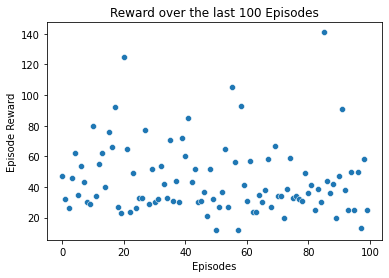

In [ ]:
plot_rewards(results3c)

#### Attention with Stacked Observations

In [ ]:
#collapse-output

config3c2 = ppo.DEFAULT_CONFIG.copy()
config3c2["env"] = "StackedStatelessCartPole"
config3c2["model"] = {
    "_use_default_native_models": True,
    "use_attention": True,
}

results3c2 = ray.tune.run("PPO", config=config3c2, stop=stop)
print("Option 3b2: Training finished successfully")

== Status ==
Current time: 2021-11-29 20:59:44 (running for 00:00:00.14)
Memory usage on this node: 8.6/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+------------------------------------------+----------+-------+
| Trial name                               | status   | loc   |
|------------------------------------------+----------+-------|
| PPO_StackedStatelessCartPole_e577f_00000 | PENDING  |       |
+------------------------------------------+----------+-------+




(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 20:59:49 (running for 00:00:05.14)
Memory usage on this node: 8.7/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+------------------------------------------+----------+-------+
| Trial name                               | status   | loc   |
|------------------------------------------+----------+-------|
| PPO_StackedStatelessCartPole_e577f_00000 | PENDING  |       |
+------------------------------------------+----------+-------+




(pid=4716) 2021-11-29 21:00:01,261	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=4716) 2021-11-29 21:00:01,261	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=4716) 2021-11-29 21:00:01,262	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=23824) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\

== Status ==
Current time: 2021-11-29 21:00:21 (running for 00:00:37.66)
Memory usage on this node: 9.4/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+------------------------------------------+----------+-------+
| Trial name                               | status   | loc   |
|------------------------------------------+----------+-------|
| PPO_StackedStatelessCartPole_e577f_00000 | RUNNING  |       |
+------------------------------------------+----------+-------+


Result for PPO_StackedStatelessCartPole_e577f_00000:
  trial_id: e577f_00000
  
== Status ==
Current time: 2021-11-29 21:00:21 (running for 00:00:37.75)
Memory usage on this node: 9.4/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials

(pid=4716) 2021-11-29 21:00:21,719	ERROR worker.py:425 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::PPO.__init__() (pid=4716, ip=127.0.0.1)
(pid=4716)   File "python\ray\_raylet.pyx", line 565, in ray._raylet.execute_task
(pid=4716)   File "python\ray\_raylet.pyx", line 569, in ray._raylet.execute_task
(pid=4716)   File "python\ray\_raylet.pyx", line 519, in ray._raylet.execute_task.function_executor
(pid=4716)   File "c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\ray\_private\function_manager.py", line 576, in actor_method_executor
(pid=4716)     return method(__ray_actor, *args, **kwargs)
(pid=4716)   File "c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\ray\util\tracing\tracing_helper.py", line 451, in _resume_span
(pid=4716)     return method(self, *_args, **_kwargs)
(pid=4716)   File "c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\ray\rllib\agents\trainer_template.py", line 1

TuneError: ('Trials did not complete', [PPO_StackedStatelessCartPole_e577f_00000])

(pid=4716) [2021-11-29 21:00:21,977 C 4716 23840] core_worker.cc:194:  Check failed: core_worker_process The core worker process is not initialized yet or already shutdown.
(pid=4716) *** StackTrace Information ***
(pid=4716)     PyInit__raylet
(pid=4716)     PyInit__raylet
(pid=4716)     PyInit__raylet
(pid=4716)     PyInit__raylet
(pid=4716)     PyFunction_Vectorcall
(pid=4716)     PyFunction_Vectorcall
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     PyErr_Clear
(pid=4716)     Py_NewInterpreter
(pid=4716)     PyThread_release_lock
(pid=471

In [ ]:
# check results
results3c2.default_metric = "episode_reward_mean"
results3c2.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3c2.best_result["episode_reward_mean"]

In [ ]:
plot_rewards(results3c2)